In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import *

In [4]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in[0.507, 0.487, 0.441]],
                                     std=[x / 255.0 for x in [0.267, 0.256, 0.276]])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in[0.507, 0.487, 0.441]],
                                     std=[x / 255.0 for x in [0.267, 0.256, 0.276]])
])

In [5]:
learning_rate=0.001
num_epochs = 40
momentum=0.9
weight_decay=1e-5
batch_size_train=256
batch_size_test=256
batch_size = 256
trainset = torchvision.datasets.CIFAR100(root = "./data",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root = "./data",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=4)


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)
print(torch.cuda.get_device_name())

Device:  cuda:0
Tesla K80


In [7]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [8]:
model = resnet50()
model = model.cuda()# I choose ResNet50. Because of Memory :(

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [10]:
total = 0
print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.0.weight 	 1728
conv1.1.weight 	 64
conv1.1.bias 	 64
conv2_x.0.residual_function.0.weight 	 4096
conv2_x.0.residual_function.1.weight 	 64
conv2_x.0.residual_function.1.bias 	 64
conv2_x.0.residual_function.3.weight 	 36864
conv2_x.0.residual_function.4.weight 	 64
conv2_x.0.residual_function.4.bias 	 64
conv2_x.0.residual_function.6.weight 	 8192
conv2_x.0.residual_function.7.weight 	 128
conv2_x.0.residual_function.7.bias 	 128
conv2_x.0.shortcut.0.weight 	 8192
conv2_x.0.shortcut.1.weight 	 128
conv2_x.0.shortcut.1.bias 	 128
conv2_x.1.residual_function.0.weight 	 8192
conv2_x.1.residual_function.1.weight 	 64
conv2_x.1.residual_function.1.bias 	 64
conv2_x.1.residual_function.3.weight 	 36864
conv2_x.1.residual_function.4.weight 	 64
conv2_x.1.residual_function.4.bias 	 64
conv2_x.1.residual_function.6.weight 	 8192
conv2_x.1.residual_function.7.weight 	 128
conv2_x.1.residual_function.7.bias 	 128
conv2_x.2.residual_function.0.weight 	 8192
conv2_x.2.r

In [11]:
use_gpu = True
train_acc = []
start = time.time()
loss_list = []
running_loss = 0
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):       
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        
        loss = criterion(outputs, labels)

            
        
        # backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 25 == 24: # print every 500 mini batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1,running_loss/25))
            running_loss = 0.0
        
        if i % 7 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))


    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data

            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data      
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)                
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)
    loss_list.append(loss.item())


end= time.time()
stopWatch = end-start
print( "Training is done")
print('Total Training Time (second):',stopWatch)

epoch: 0 0/196
epoch: 0 7/196
epoch: 0 14/196
epoch: 0 21/196
[1,    25] loss: 4.736
epoch: 0 28/196
epoch: 0 35/196
epoch: 0 42/196
[1,    50] loss: 4.358
epoch: 0 49/196
epoch: 0 56/196
epoch: 0 63/196
epoch: 0 70/196
[1,    75] loss: 4.180
epoch: 0 77/196
epoch: 0 84/196
epoch: 0 91/196
epoch: 0 98/196
[1,   100] loss: 4.031
epoch: 0 105/196
epoch: 0 112/196
epoch: 0 119/196
[1,   125] loss: 3.942
epoch: 0 126/196
epoch: 0 133/196
epoch: 0 140/196
epoch: 0 147/196
[1,   150] loss: 3.825
epoch: 0 154/196
epoch: 0 161/196
epoch: 0 168/196
[1,   175] loss: 3.773
epoch: 0 175/196
epoch: 0 182/196
epoch: 0 189/196
Accuracy train 11 %
Accuracy test 11 %
epoch: 1 0/196
epoch: 1 7/196
epoch: 1 14/196
epoch: 1 21/196
[2,    25] loss: 6.805
epoch: 1 28/196
epoch: 1 35/196
epoch: 1 42/196
[2,    50] loss: 3.568
epoch: 1 49/196
epoch: 1 56/196
epoch: 1 63/196
epoch: 1 70/196
[2,    75] loss: 3.537
epoch: 1 77/196
epoch: 1 84/196
epoch: 1 91/196
epoch: 1 98/196
[2,   100] loss: 3.476
epoch: 1 10

In [16]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [17]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('F1 score: %f' % f1_score(actuals, predictions, average='weighted'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

F1 score: 0.672507
Accuracy score: 0.670600


[[95  0  0 ...  0  0  0]
 [ 0 64  0 ...  0  0  2]
 [ 3  0 58 ...  0  3  0]
 ...
 [ 0  0  0 ... 61  1  0]
 [ 0  0  3 ...  0 67  0]
 [ 0  0  0 ...  0  0 66]]


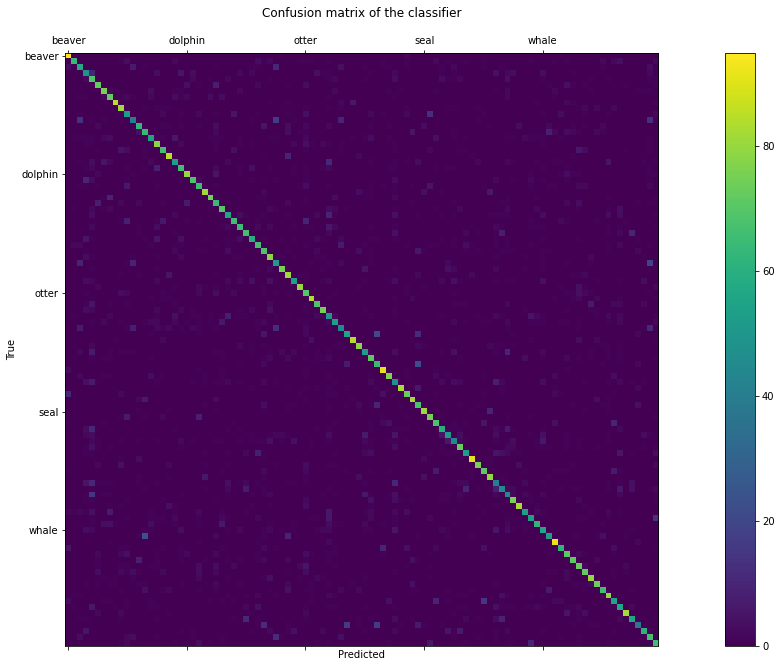

In [18]:
cm = confusion_matrix(actuals, predictions)
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
 print(classification_report(actuals, predictions, target_names=classes, digits=5))

                   precision    recall  f1-score   support

           beaver    0.76000   0.95000   0.84444       100
          dolphin    0.86486   0.64000   0.73563       100
            otter    0.54206   0.58000   0.56039       100
             seal    0.43750   0.49000   0.46226       100
            whale    0.36126   0.69000   0.47423       100
         aquarium    0.69231   0.72000   0.70588       100
             fish    0.76000   0.76000   0.76000       100
              ray    0.63158   0.72000   0.67290       100
            shark    0.93407   0.85000   0.89005       100
            trout    0.68333   0.82000   0.74545       100
          orchids    0.50476   0.53000   0.51707       100
          poppies    0.53947   0.41000   0.46591       100
            roses    0.68478   0.63000   0.65625       100
       sunflowers    0.57658   0.64000   0.60664       100
           tulips    0.67901   0.55000   0.60773       100
          bottles    0.63934   0.78000   0.70270       